In [18]:
%reset -f 
%matplotlib inline
import importlib
import numpy as np
from matplotlib.animation import FuncAnimation
import os
from datetime import datetime
from IPython.display import HTML, display
import aif_functions_rollout as aif


pwd = os.path.abspath('') + "/"
print(pwd)
importlib.reload(aif)

c:\Users\qbr5kx\OneDrive - University of Virginia\Desktop\UVA\PhD Scratch\Active_Epistemic_Inference\aif_multi_robot/


<module 'aif_functions_rollout' from 'c:\\Users\\qbr5kx\\OneDrive - University of Virginia\\Desktop\\UVA\\PhD Scratch\\Active_Epistemic_Inference\\aif_multi_robot\\aif_functions_rollout.py'>

Initial Prior:  [0.5 0.5]
Max iterations reached.
Agents did not converge to the same goal within the maximum iterations.
Final Prior:  [array([0.5109695, 0.4890305]), array([0.49904131, 0.50095869]), array([0.51201728, 0.48798272])]
Agent Types:  ['A' 'B' 'B']


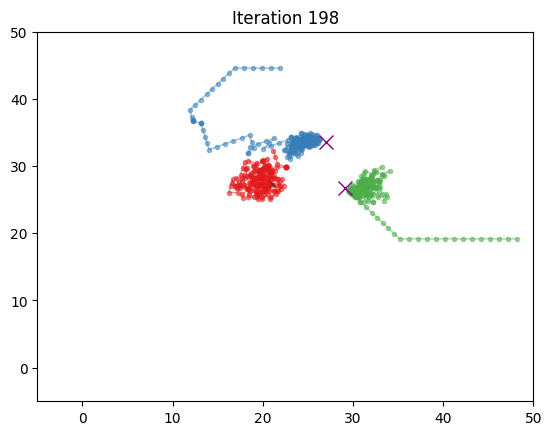

In [19]:
# Re-define the environment and simulation parameters here
interactive = True  # Set to True to display the animation in the notebook
use_ep = False  # Set to True to use EP, False to use the standard algorithm
args = {}
# draft_results = []

random_seed = 0  # Random seed #2,5,6 are interesting; 6 diverges, 2 & 5 converges ---- 6 is the best for our scenario ->
# 6 is the best for the following reasons:
# If any agent except the third agent is type B, then the agents converge to the correct goal
# If the third agent is type B, the agents are unable to converge to the same goal
np.random.seed(random_seed)  # Set random seed
# Set random goals
env_size = 50  # Environment size
iterations_per_episode = 200  # Number of iterations per episode
num_goals = 2  # Number of goals
num_agents = 3  # Number of agents
list_types = ['A','B']
goals = np.random.uniform(5,env_size-5,size=(num_goals, 2))  # Goal positions
# goals = np.array([[0,0],[env_size-5,0]], dtype=float)  # Goal positions
agent_positions = np.hstack((np.random.uniform(0,env_size,size=(num_agents, 2)),np.zeros((num_agents,1))))  # Initial agent positions
args['goals'] = np.copy(goals)
args['agent_types'] = np.random.choice(list_types,num_agents) #['B','B','A']#np.random.choice(list_types,num_agents)  # Agent types
args['agent_positions'] = agent_positions
args['velocity_options'] = [0.0, 0.01, 0.1, 0.5, 1.0]  # Velocity options for the agents
args['num_heading_options'] = 8  # Number of heading options
args['heading_options'] = np.linspace(-np.pi,np.pi,args['num_heading_options'],endpoint=True)  # Heading options for the agents
args['observation_error_std'] = 0.0  # Observation noise standard deviation

args['max_distance_measure'] = env_size  # Maximum distance measure for likelihood calculation
args['max_heading_measure'] = np.pi  # Maximum heading measure for likelihood calculation
args['prior'] = np.ones(goals.shape[0]) / goals.shape[0]  # Prior over goals
args['use_ep'] = use_ep  # Use EP

print("Initial Prior: ", args['prior'])

# Run the simulation
final_positions, goal_converged, num_frames, return_args, prior, avg_nrg_over_time = aif.run_simulation(args, iterations_per_episode)
print("Final Prior: ", prior)
print("Agent Types: ", args['agent_types'])
energy_results, ending_energy = aif.parse_free_energy_scores(avg_nrg_over_time, num_frames)
# draft_results.append([random_seed, goal_converged, args['agent_types'], prior, use_ep, energy_results, ending_energy])


# Create animation
plt_sim = aif.PlotSim(num_agents,goals,env_size)
ani = FuncAnimation(plt_sim.fig, plt_sim.update, frames=range(num_frames), init_func=plt_sim.init, fargs = (return_args,), blit=True, repeat=True)

# Save the animation as a video
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

if goal_converged == None and not interactive:
    filepath = pwd + "videos/two_goals_choice_NO_convergence_seed" + str(random_seed) + "_EP" + str(args['use_ep']) + "_" + current_time + ".mp4"
    ani.save(filepath, writer='ffmpeg', fps=3, dpi=300)
    # Save location of the final image
    print("Image saved as: ", filepath)
elif not interactive:
    filepath = pwd + "videos/two_goals_choice_ok_seed" + str(random_seed) + "_EP" + str(args['use_ep']) + "_" + current_time + ".mp4"
    ani.save(filepath, writer='ffmpeg', fps=3, dpi=300)
    # Save location of the final image
    print("Image saved as: ", filepath)
else:
    display(HTML(ani.to_jshtml())) # Use an interactive backend for animation


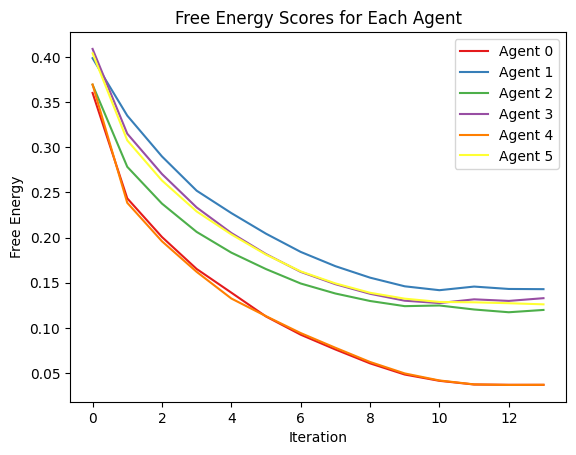

In [11]:
energy_results, ending_energy = aif.parse_free_energy_scores(avg_nrg_over_time, num_frames)
aif.plot_energy(energy_results, num_agents)

In [8]:
# Calculate distance to final goals
final_distances = np.zeros((num_agents, goals.shape[0]))
for i in range(num_agents):
    for j in range(goals.shape[0]):
        final_distances[i,j] = np.linalg.norm(final_positions[i,:2] - goals[j,:])
print("Final distances: ", final_distances)


Final distances:  [[10.4605414   1.16716409]
 [10.45314845  0.79625775]
 [ 9.75305354  0.48351174]]


In [67]:
# Scratch code for testing

goals = np.array([[0,0],[0.,10.]])
my_pose = np.array([14.12709979, 12.76192634,  0.])
other_pose = np.array([6.30305407,  7.28140647,  0.])
saliences = np.zeros(goals.shape[0])
goal_azimuths = np.arctan2(goals[:, 1] - my_pose[1], goals[:, 0] - my_pose[0])
observed_azimuth = np.arctan2(other_pose[1] - my_pose[1], other_pose[0] - my_pose[0])
relative_azimuths = np.abs((goal_azimuths - observed_azimuth + np.pi) % (2 * np.pi) - np.pi)
azimuth_salience = 1./8 * np.exp(- relative_azimuths / np.pi)  # normalize and invert to make smaller angles more salient
saliences += azimuth_salience
# Compute if observed robot is heading towards the goal
# heading_to_goal = (np.arctan2(goals[:, 1] - observation['position'][1], goals[:, 0] - observation['position'][0]) - observation['heading'] + np.pi) % (2 * np.pi) - np.pi
# heading_salience = 1./8 * np.exp(- np.abs(heading_to_goal) / np.pi)
# saliences += heading_salience


print("Goal Azimuth: ", goal_azimuths)
print("Relative Azimuth: ", azimuth_salience)
print("Observed Azimuth: ", observed_azimuth)
print("Salience: ", saliences)
# print("Heading Salience: ", heading_salience)
print(np.exp(0.8/np.pi))

Goal Azimuth:  [-2.40692159 -2.9485224 ]
Relative Azimuth:  [0.1201765  0.10942825]
Observed Azimuth:  -2.5305504167886905
Salience:  [0.1201765  0.10942825]
1.2900073408606396
